In [1]:
## Import Packages
from __future__ import print_function

import numpy as np
import pandas as pd
from itertools import product

#Astro Software
import astropy.units as units
from astropy.coordinates import SkyCoord
from astropy.io import fits

#Plotting Packages
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib import rcParams

import seaborn as sns

from PIL import Image

from yt.config import ytcfg
import yt
import yt.units as u

#Scattering NN
import torch
import torch.nn.functional as F
from torch import optim
from kymatio.torch import Scattering2D
device = "cpu"

#Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.decomposition import PCA, FastICA

import skimage
from skimage import filters

from scipy.optimize import curve_fit
from scipy import linalg
from scipy import stats
from scipy.signal import general_gaussian

#I/O
import h5py
import pickle
import glob
import copy
import time

#Plotting Style
%matplotlib inline
plt.style.use('dark_background')
rcParams['text.usetex'] = False
rcParams['axes.titlesize'] = 20
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['legend.fontsize'] = 12
rcParams['axes.labelsize'] = 20
rcParams['font.family'] = 'sans-serif'

#Threading
torch.set_num_threads=2
from multiprocessing import Pool

import ntpath
def path_leaf(path):
    head, tail = ntpath.split(path)
    out = os.path.splitext(tail)[0]
    return out

def hd5_open(file_name,name):
    f=h5py.File(file_name,'r', swmr=True)
    data = f[name][:]
    f.close()
    return data

from matplotlib.colors import LinearSegmentedColormap
cdict1 = {'red':   ((0.0, 0.0, 0.0),
                   (0.5, 0.0, 0.0),
                   (1.0, 1.0, 1.0)),

         'green': ((0.0, 0.0, 0.0),
                   (1.0, 0.0, 0.0)),

         'blue':  ((0.0, 0.0, 1.0),
                   (0.5, 0.0, 0.0),
                   (1.0, 0.0, 0.0))
        }
blue_red1 = LinearSegmentedColormap('BlueRed1', cdict1,N=5000)

from sklearn.preprocessing import StandardScaler

/opt/miniconda3/envs/IWST/lib/python3.8/_collections_abc.py:666: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  self[key]


In [2]:
cifar10_train = hd5_open('../scratch_AKS/data/cifar10_train.h5','main/data')
cifar10_test = hd5_open('../scratch_AKS/data/cifar10_test.h5','main/data')

In [10]:
def DHC_iso_vec(wst,J,L):
    (nk, Nd) = np.shape(wst)
    S0 = wst[:,0:2]
    S1 = wst[:,2:J*L+2]
    S2 = np.reshape(wst[:,J*L+3:],(nk,(J*L+1),(J*L+1)))
    
    S1iso = np.zeros((nk,J))
    for j1 in range(J):
        for l1 in range(L):
            S1iso[:,j1] += S1[:,l1*J+j1]
    
    S2iso = np.zeros((nk,J,J,L))
    for j1 in range(J):
        for j2 in range(J):
            for l1 in range(L):
                for l2 in range(L):
                    deltaL = np.mod(l1-l2,L)
                    S2iso[:,j1,j2,deltaL] += S2[:,l1*J+j1,l2*J+j2]
                    
    Sphi1 = np.zeros((nk,J))
    for j1 in range(J):
        for l1 in range(L):
            Sphi1[:,j1] += S2[:,l1*J+j1,L*J]
            
    Sphi2 = np.zeros((nk,J))
    for j1 in range(J):
        for l1 in range(L):
            Sphi2[:,j1] += S2[:,L*J,l1*J+j1]
            
    return np.hstack((S0,S1iso,wst[:,J*L+2].reshape(nk,1),S2iso.reshape(nk,J*J*L),Sphi1,Sphi2,S2[:,L*J,L*J].reshape(nk,1)))

In [16]:
cifar10_test_iso = DHC_iso_vec(cifar10_test,5,8)
cifar10_train_iso = DHC_iso_vec(cifar10_train,5,8)

In [4]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torchvision.datasets as ds

train_ds = ds.CIFAR10(root='./data_cache',train=True,download=True, transform=None)
test_ds = ds.CIFAR10(root='./data_cache',train=False,download=True, transform=None)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LinearRegression

In [6]:
lb = LabelBinarizer()
test_y_onehot = lb.fit_transform(np.array(test_ds.targets))

In [7]:
lb = LabelBinarizer()
train_y_onehot = lb.fit_transform(np.array(train_ds.targets))

In [8]:
lb.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [9]:
from sklearn.linear_model import LinearRegression

In [17]:
reg = LinearRegression().fit(cifar10_train_iso, train_y_onehot)
reg.score(cifar10_test_iso, test_y_onehot)

0.14387809255286627

In [19]:
y_pred = reg.predict(cifar10_test_iso)
y_pred.shape

(10000, 10)

In [20]:
np.mean(np.square(y_pred-test_y_onehot))

0.0770509716702344

In [22]:
np.count_nonzero(np.argmax(y_pred,axis=1)-np.array(test_ds.targets))/10000

0.5702

In [23]:
class_pred = np.argmax(y_pred,axis=1)

In [24]:
def cm_eval(y_pred, y_true,n_classes):
    cm = np.zeros((n_classes,n_classes))
    for indx in range(y_pred.shape[0]):
        cm[y_true[indx],y_pred[indx]] += 1
    return cm.astype(int)

In [25]:
cm_1 = cm_eval(class_pred,np.array(test_ds.targets),10)

In [26]:
def cm_plot(cm,label_list):
    prec = np.diag(cm).sum()/np.sum(cm)
    print('Accuracy' + str(prec))
    cmap_normal = (cm.T/cm.sum(axis=1)).T
    
    ## Good plots
    vmin=0
    vmax=cm.shape[0]
    marker_size = 10

    from matplotlib import cm as cmplt
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    rgba_colors = [cmplt.Spectral(norm(indx)) for indx, i in enumerate(label_list)]
    color_order = ["black", "white"]
    color_map = "gray"
    colormap='Spectral'
    
    fig = plt.figure(figsize=(8,8),dpi=150)

    ax = fig.add_subplot(1,1,1)    
    ax.imshow(cmap_normal,
          interpolation='none',
          cmap=color_map,
          aspect='equal',
          vmin=0,vmax=1)

    ax.set_xticks(np.arange(cm.shape[0]))
    ax.set_yticks(np.arange(cm.shape[1]))
    
    for ytick, color in zip(ax.get_yticklabels(), rgba_colors):
        ytick.set_color(color)

    ax.set_xticklabels(label_list)
    ax.set_yticklabels(label_list)

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    plt.setp(ax.get_xticklabels(), rotation=90, ha="right",va='center',
             rotation_mode="anchor")
    plt.title('Test-Train Fidelity ({:.2f}%)'.format(100*prec))

    # Loop over data dimensions and create text annotations.
    textcolors=color_order
    threshold = 0.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if cm[i, j] != 0:
                text = ax.text(j, i, cm[i, j],
                               ha="center", va="center", 
                               color=textcolors[int(cmap_normal[i, j] < threshold)])
    ax.margins(x=0.1, y=0.05)
    plt.show()
    
    return np.diag(cmap_normal)

Accuracy0.4298


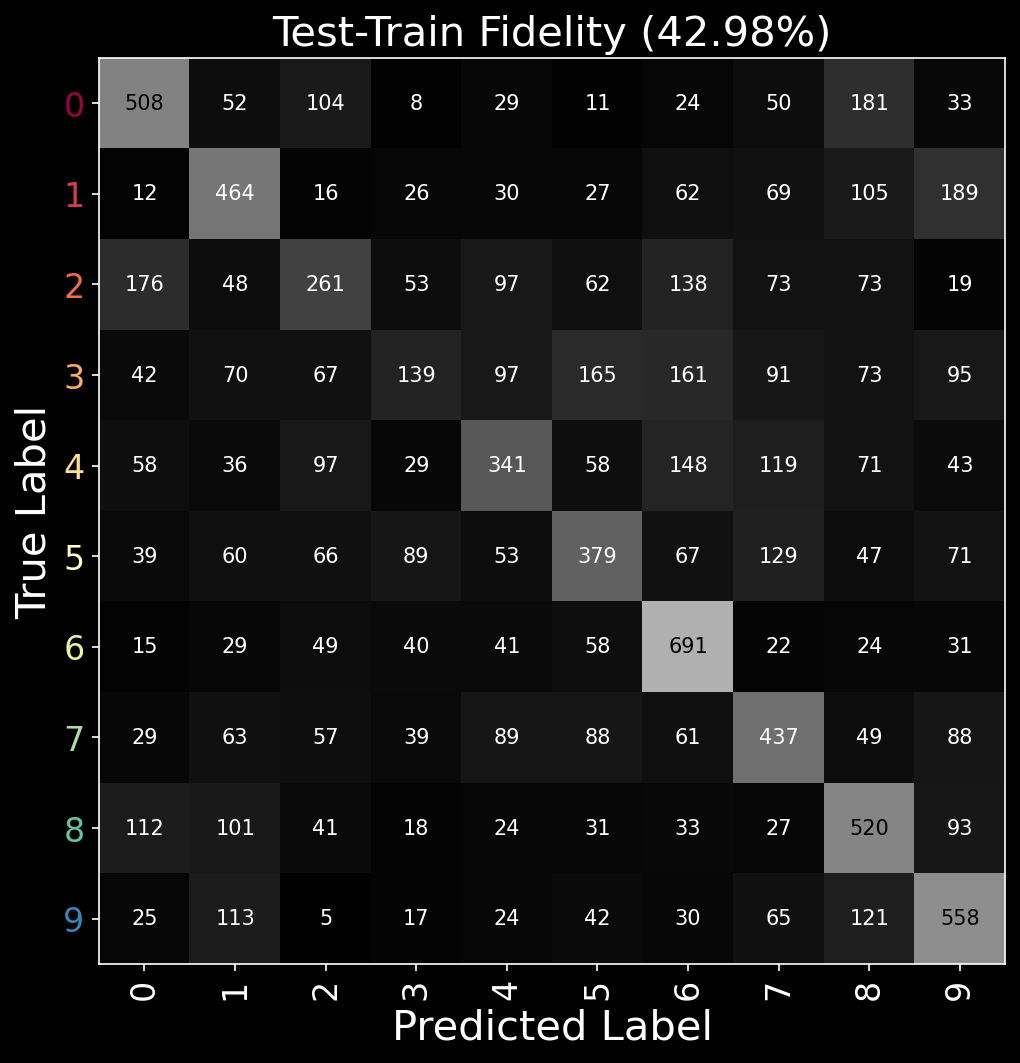

array([0.508, 0.464, 0.261, 0.139, 0.341, 0.379, 0.691, 0.437, 0.52 ,
       0.558])

In [27]:
cm_plot(cm_1,[0,1,2,3,4,5,6,7,8,9])

In [30]:
import julia

In [34]:
julia.install()


Precompiling PyCall...
Precompiling PyCall... DONE
PyCall is installed and built successfully.


In [39]:
from julia.api import Julia
jl = Julia(compiled_modules=False)

In [43]:
import julia

In [45]:
from julia import Main

In [46]:
Main.xs = [1, 2, 3]

In [47]:
Main.eval("sin.(xs)")

array([0.84147098, 0.90929743, 0.14112001])

In [48]:
import julia.Base
from julia.Base import Enums    # import a submodule
from julia.Base import sin  

In [49]:
from julia import Base

In [50]:
Base.sind(90)

1.0

In [54]:
%load_ext julia.magic

Initializing Julia interpreter. This may take some time...


In [57]:
%%julia
push!(LOAD_PATH, "/Users/saydjari/Dropbox/GradSchool_AKS/Doug/Projects/DHC/main/")

['@',
 '@v#.#',
 '@stdlib',
 '/Users/saydjari/Dropbox/GradSchool_AKS/Doug/Projects/DHC/main/']

In [59]:
%%julia
import DHC_2DUtils

In [62]:
%%julia 
filter_hash = DHC_2DUtils.fink_filter_hash(1,8,nx=128,wd=2);

In [67]:
%%julia 
A = rand(128,128)
WST_vec = DHC_2DUtils.DHC_compute(A,filter_hash)

[0.49814518735629526,
 0.08304342178345313,
 0.039097573665554386,
 0.009402155912530458,
 0.002481469848761696,
 0.0003766040193402787,
 7.921328349351152e-05,
 0.040117494429605716,
 0.010066371661115178,
 0.002407446771277208,
 0.00044940638907290493,
 0.00016921311831443188,
 0.03847651061543859,
 0.009878340232861582,
 0.0024304735690027467,
 0.0005387083844146004,
 0.00015974282007838082,
 0.038875689408377066,
 0.009246926724312312,
 0.002346274060556625,
 0.000586403040802774,
 9.940152744095999e-05,
 0.04039444876349076,
 0.009373756270149509,
 0.002191689256727454,
 0.000550863993305442,
 8.632784078500271e-05,
 0.0400235590394004,
 0.00962271862609345,
 0.002374517915826206,
 0.0006013003634340829,
 6.459319585443614e-05,
 0.03788778514362014,
 0.009758679307366897,
 0.002514780501993824,
 0.0005176252950760409,
 5.3129617994129e-05,
 0.03683957531072095,
 0.009476914711387502,
 0.002490174428825678,
 0.00034669189882659957,
 4.5205720741196067e-05,
 0.00030163709736711643,


In [69]:
%%julia
filter_hash = DHC_2DUtils.fink_filter_hash(1,8,nx=256,wd=2);
A = rand(256,256)
WST_vec = DHC_2DUtils.DHC_compute(A,filter_hash)

[0.5003370441175464,
 0.0835846128463633,
 0.0391974064336759,
 0.009372267157952667,
 0.0022488834445292157,
 0.0004462597809881569,
 8.241577982930254e-05,
 3.5671515108866576e-05,
 0.03905386827289144,
 0.009402935716559991,
 0.002227148722227519,
 0.0005013659796286365,
 8.394419663710125e-05,
 4.6618895720928615e-05,
 0.038532688191964565,
 0.009289511511880557,
 0.0023448644782918114,
 0.0006022356353011557,
 7.178681839860046e-05,
 3.599779720406838e-05,
 0.03806767158193238,
 0.009170906418594737,
 0.0024302598925340898,
 0.0006277602336238156,
 7.568835553014021e-05,
 3.720269775647339e-05,
 0.03812083308014807,
 0.009305390222728426,
 0.002544635645724514,
 0.0006136724049175548,
 0.00015073096124860907,
 6.415694454368017e-05,
 0.03817190289445718,
 0.009515848683565826,
 0.002645658448896953,
 0.0006078896363859446,
 0.00022050635893852162,
 5.642525729394889e-05,
 0.03939887402499462,
 0.009324237088710656,
 0.00255050393903797,
 0.0005361508488246994,
 0.00017947641804150

In [74]:
B = np.random.rand(256)

In [75]:
%%julia
py"B"

array([0.25022457, 0.3378813 , 0.31001903, 0.06752805, 0.57859114,
       0.56875657, 0.01032364, 0.29545433, 0.08293691, 0.2744874 ,
       0.75811011, 0.76946743, 0.99391667, 0.59542853, 0.28984153,
       0.80194013, 0.92658642, 0.97995765, 0.86953333, 0.43280942,
       0.8051237 , 0.82404466, 0.82991753, 0.64476458, 0.77134525,
       0.044317  , 0.55106641, 0.37204113, 0.23646976, 0.17482868,
       0.27059621, 0.29671954, 0.98476928, 0.83676117, 0.53873607,
       0.58287895, 0.42097288, 0.53846764, 0.18385046, 0.70138592,
       0.85252501, 0.26341865, 0.59939262, 0.97317098, 0.06188549,
       0.17405268, 0.86674853, 0.41254473, 0.30382401, 0.88047101,
       0.68833033, 0.96831158, 0.74054652, 0.41238181, 0.5796784 ,
       0.11670151, 0.21905089, 0.80219182, 0.56000228, 0.09813153,
       0.81309763, 0.87763423, 0.40215901, 0.03714165, 0.87668823,
       0.46116663, 0.71462661, 0.56925144, 0.26886719, 0.62838442,
       0.53109218, 0.61873165, 0.42960556, 0.90683629, 0.55489

In [83]:
A = np.array(Main.eval("WST_vec"))

In [85]:
A.shape

(2452,)